In [1]:
import spacy

import pandas as pd
import datatable as dt
import numpy as np
import re

import nltk
import nltk.corpus  
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.text import Text

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
import pickle

from joblib import dump, load

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

from collections import Counter

import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [2]:
with open('sent_tops_words.pkl', 'rb') as f:
    sentiments = pickle.load(f)

In [3]:
data1 = dt.fread('clean_df.csv')
df = data1.to_pandas()

In [11]:
nlp = spacy.load("en_core_web_sm",disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"])

In [3]:
sentiments.head()

,text,predicted_class,probability_negative,probability_positive,word_count,topic,date
0,LegalTech Artificial Intelligence Market 2019 ...,negative,0.993451,0.006549,910,18,2020-02-26
1,"Observation, Simulation, And AI Join Forces To...",negative,0.989872,0.010128,847,16,2021-07-05
2,Artificial intelligence yields new antibiotic ...,positive,0.440235,0.559765,160,16,2020-02-23
3,"Forget ML, AI and Industry 4.0 – obsolescence ...",negative,0.694599,0.305401,1892,8,2021-03-26
4,How You Should Validate Machine Learning Model...,negative,1.000000,0.000000,3341,16,2023-07-21


In [6]:
df.head()

,url,date,language,title,text,cleaned_text,tokens
0,http://galusaustralis.com/2020/02/486473/legal...,2020-02-26,en,LegalTech Artificial Intelligence Market 2019 ...,LegalTech Artificial Intelligence Market 2019 ...,LegalTech Artificial Intelligence Market 2019 ...,"['legaltech', 'artificial', 'intelligence', 'm..."
1,http://spaceref.com/astronomy/observation-simu...,2021-07-05,en,"Observation, Simulation, And AI Join Forces To...","\n\nObservation, Simulation, And AI Join Force...","Observation, Simulation, And AI Join Forces To...","['observation', 'simulation', 'and', 'ai', 'jo..."
2,http://usweekly.com/news/17/40964/Artificial-i...,2020-02-23,en,Artificial intelligence yields new antibiotic ...,\n\n\nArtificial intelligence yields new antib...,Artificial intelligence yields new antibiotic ...,"['artificial', 'intelligence', 'yields', 'new'..."
3,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence ...","\n\nForget ML, AI and Industry 4.0 – obsolesce...","Forget ML, AI and Industry 4.0 – obsolescence ...","['forget', 'ml', 'ai', 'industry', 'obsolescen..."
4,http://www.huewire.com/how-you-should-validate...,2023-07-21,en,How You Should Validate Machine Learning Model...,\n\nHow You Should Validate Machine Learning M...,How You Should Validate Machine Learning Model...,"['how', 'you', 'should', 'validate', 'machine'..."


In [32]:
test = df.iloc[0:10000]

In [36]:
texts = df['cleaned_text'].tolist()

In [37]:
def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

In [38]:
%%time
batch_size = 2000
entities = []
for i in range(0, len(texts), batch_size):
    batch = texts[i:i + batch_size]
    docs = list(nlp.pipe(batch))
    batch_entities = [[(ent.text, ent.label_) for ent in doc.ents] for doc in docs]
    entities.extend(batch_entities)
    
    if i % 100 == 0:
        print(f"Finished Article: {i}")

Finished Article: 0
Finished Article: 2000
Finished Article: 4000
Finished Article: 6000
Finished Article: 8000
Finished Article: 10000
Finished Article: 12000
Finished Article: 14000
Finished Article: 16000
Finished Article: 18000
Finished Article: 20000
Finished Article: 22000
Finished Article: 24000
Finished Article: 26000
Finished Article: 28000
Finished Article: 30000
Finished Article: 32000
Finished Article: 34000
Finished Article: 36000
Finished Article: 38000
Finished Article: 40000
Finished Article: 42000
Finished Article: 44000
Finished Article: 46000
Finished Article: 48000
Finished Article: 50000
Finished Article: 52000
Finished Article: 54000
Finished Article: 56000
Finished Article: 58000
Finished Article: 60000
Finished Article: 62000
Finished Article: 64000
Finished Article: 66000
Finished Article: 68000
Finished Article: 70000
Finished Article: 72000
Finished Article: 74000
Finished Article: 76000
Finished Article: 78000
Finished Article: 80000
Finished Article: 82000


In [39]:
%%time
df['entities'] = entities

CPU times: total: 125 ms
Wall time: 260 ms


In [59]:
%%time
with open('entities.pkl', 'wb') as f:
    pickle.dump(df, f)

CPU times: total: 54.4 s
Wall time: 4min 17s


In [2]:
%%time
with open('entities.pkl', 'rb') as f:
    df = pickle.load(f)

CPU times: total: 12 s
Wall time: 38.1 s


In [61]:
df.head()

,url,date,language,title,text,cleaned_text,tokens,entities
0,http://galusaustralis.com/2020/02/486473/legal...,2020-02-26,en,LegalTech Artificial Intelligence Market 2019 ...,LegalTech Artificial Intelligence Market 2019 ...,LegalTech Artificial Intelligence Market 2019 ...,"['legaltech', 'artificial', 'intelligence', 'm...",[(LegalTech Artificial Intelligence Market 201...
1,http://spaceref.com/astronomy/observation-simu...,2021-07-05,en,"Observation, Simulation, And AI Join Forces To...","\n\nObservation, Simulation, And AI Join Force...","Observation, Simulation, And AI Join Forces To...","['observation', 'simulation', 'and', 'ai', 'jo...","[(Observation, Simulation, ORG), (AI Join Forc..."
2,http://usweekly.com/news/17/40964/Artificial-i...,2020-02-23,en,Artificial intelligence yields new antibiotic ...,\n\n\nArtificial intelligence yields new antib...,Artificial intelligence yields new antibiotic ...,"['artificial', 'intelligence', 'yields', 'new'...","[(23, CARDINAL), (Todays newsWorldU.S. Nationa..."
3,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence ...","\n\nForget ML, AI and Industry 4.0 – obsolesce...","Forget ML, AI and Industry 4.0 – obsolescence ...","['forget', 'ml', 'ai', 'industry', 'obsolescen...","[(AI, ORG), (Editor, PERSON), (Multimedia, GPE..."
4,http://www.huewire.com/how-you-should-validate...,2023-07-21,en,How You Should Validate Machine Learning Model...,\n\nHow You Should Validate Machine Learning M...,How You Should Validate Machine Learning Model...,"['how', 'you', 'should', 'validate', 'machine'...","[(Patryk Miziuła, PERSON), (PhD, WORK_OF_ART),..."


In [3]:
%%time

entity_counter = Counter()
location_counter = Counter()
person_counter = Counter()

for entities in df['entities']:
    for entity, label in entities:
        if label == 'ORG':
            entity_counter[entity] += 1
        elif label in ['GPE', 'LOC']: 
            location_counter[entity] += 1
        elif label == 'PERSON': 
            person_counter[entity] += 1


top_companies = entity_counter.most_common(50)
top_people = person_counter.most_common(50)
top_locations = location_counter.most_common(50)

CPU times: total: 9.64 s
Wall time: 15.2 s


In [4]:
top_companies

[('AI', 1237635),
 ('Google', 118367),
 ('Microsoft', 114467),
 ('Gray Media Group', 113739),
 ('PRNewswire', 48872),
 ('Amazon', 38174),
 ('IBM', 35056),
 ('Artificial Intelligence', 34401),
 ('COVID-19', 33044),
 ('AP', 28205),
 ('ML', 27894),
 ('Apple', 26833),
 ('Bard', 23319),
 ('Android', 23028),
 ('Company', 22211),
 ('Gray Media Group, Inc.', 19367),
 ('EU', 19198),
 ('Meta', 19029),
 ('Intel', 17458),
 ('Forecast', 17451),
 ('NYSE', 17373),
 ('NVIDIA', 14721),
 ('Nvidia', 14293),
 ('DIGI', 13777),
 ('Bing', 13388),
 ('Congress', 13260),
 ('DIGI COMMUNICATIONS N.V.', 13050),
 ('The Associated Press', 12669),
 ('YouTube', 11934),
 ('Tesla', 11846),
 ('FCC', 11510),
 ('Trump', 11438),
 ('Healthcare', 11223),
 ('Baidu', 10814),
 ('LLC', 10535),
 ('GPT', 10401),
 ('Reuters', 10061),
 ('NPR', 9499),
 ('Samsung', 9477),
 ('GPU', 9314),
 ('TwitterShare', 9306),
 ('FacebookShare', 9254),
 ('Machine Learning', 8986),
 ('TikTok', 8862),
 ('Associated Press Posted', 8749),
 ('FDA', 8708),

In [5]:
top_people

[('Twitter', 22435),
 ('Biden', 18422),
 ('GPT-4', 15592),
 ('Musk', 11339),
 ('Elon Musk', 10860),
 ('Sam Altman', 9124),
 ('AI', 6828),
 ('Joe Biden', 6226),
 ('AdvertisingAt Gray', 5605),
 ('Midjourney', 5359),
 ('Generative AI', 5093),
 ('Size', 5073),
 ('COVID-19', 4694),
 ('Donald Trump', 4281),
 ('OpenAI', 4242),
 ('Covid', 4148),
 ('Bard', 3884),
 ('Google Cloud', 3860),
 ('MapRSSCookie SettingsCopyright', 3823),
 ('Weather Alerts Alerts', 3684),
 ('Sundar Pichai', 3562),
 ('Mark Zuckerberg', 3510),
 ('CDT', 3460),
 ('TravelAmusement Parks', 3382),
 ('Machine Learning', 3366),
 ('Bloomberg', 3325),
 ('Schumer', 3272),
 ('Anthropic', 3230),
 ('Putin', 3212),
 ('Harry', 3199),
 ('Gmail', 3188),
 ('Outlook', 3138),
 ('Kim Kardashian', 3096),
 ('Siri', 3050),
 ('Jun.', 3011),
 ('Adobe', 2920),
 ('Jones', 2908),
 ('Dashboard Profile', 2881),
 ('Pichai', 2880),
 ('Privacy Policy', 2787),
 ('Pixel', 2754),
 ('reCAPTCHA', 2726),
 ('Alert Weather', 2694),
 ('CenterProfNet Cision', 2637)

In [6]:
top_locations

[('OpenAI', 94822),
 ('US', 90207),
 ('India', 68667),
 ('U.S.', 66119),
 ('China', 64503),
 ('UK', 43271),
 ('Us', 39240),
 ('Europe', 35529),
 ('Canada', 25836),
 ('Japan', 24355),
 ('New York', 23552),
 ('California', 20764),
 ('Russia', 20599),
 ('North America', 19952),
 ('the United States', 19142),
 ('Germany', 18571),
 ('Texas', 18024),
 ('Australia', 17823),
 ('France', 17770),
 ('AI', 17108),
 ('London', 16153),
 ('LinkedIn', 15808),
 ('Ukraine', 14521),
 ('Washington', 13979),
 ('Africa', 13725),
 ('Italy', 13383),
 ('San Francisco', 13221),
 ('Florida', 12505),
 ('Calif.', 11079),
 ('America', 11060),
 ('Videos', 10837),
 ('Taiwan', 10345),
 ('Brazil', 9935),
 ('Israel', 9840),
 ('Hollywood', 9390),
 ('Spain', 9026),
 ('Asia', 8875),
 ('Alphabet', 8676),
 ('South Korea', 8406),
 ('Mexico', 8251),
 ('United States', 8110),
 ('LA', 8010),
 ('Los Angeles', 7958),
 ('New York City', 7889),
 ('Singapore', 7584),
 ('Middle East', 7546),
 ('USA', 7374),
 ('Pakistan', 7101),
 ('Nvi

In [55]:
comps = pd.DataFrame(top_companies, columns=['Company', 'Company_values'])
locs = pd.DataFrame(top_locations, columns = ['Locations', 'Locations_values'])
people = pd.DataFrame(top_people, columns = ['People', 'People_values'])

data = pd.concat([comps, locs, people], axis=1)

In [57]:
data.to_csv('top_ner.csv', index=False)

## Time charts

In [36]:
df.head()

,url,date,language,title,text,cleaned_text,tokens,month_year,generative ai,gpt,conversational ai
0,http://galusaustralis.com/2020/02/486473/legal...,2020-02-26,en,LegalTech Artificial Intelligence Market 2019 ...,LegalTech Artificial Intelligence Market 2019 ...,LegalTech Artificial Intelligence Market 2019 ...,"['legaltech', 'artificial', 'intelligence', 'm...",2020-02,0,0,0
1,http://spaceref.com/astronomy/observation-simu...,2021-07-05,en,"Observation, Simulation, And AI Join Forces To...","\n\nObservation, Simulation, And AI Join Force...","Observation, Simulation, And AI Join Forces To...","['observation', 'simulation', 'and', 'ai', 'jo...",2021-07,0,0,0
2,http://usweekly.com/news/17/40964/Artificial-i...,2020-02-23,en,Artificial intelligence yields new antibiotic ...,\n\n\nArtificial intelligence yields new antib...,Artificial intelligence yields new antibiotic ...,"['artificial', 'intelligence', 'yields', 'new'...",2020-02,0,0,0
3,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence ...","\n\nForget ML, AI and Industry 4.0 – obsolesce...","Forget ML, AI and Industry 4.0 – obsolescence ...","['forget', 'ml', 'ai', 'industry', 'obsolescen...",2021-03,0,0,0
4,http://www.huewire.com/how-you-should-validate...,2023-07-21,en,How You Should Validate Machine Learning Model...,\n\nHow You Should Validate Machine Learning M...,How You Should Validate Machine Learning Model...,"['how', 'you', 'should', 'validate', 'machine'...",2023-07,0,0,0


In [52]:
df['date'] = pd.to_datetime(df['date'])
df['month_year'] = df['date'].dt.to_period('M')

In [53]:
%%time
phrases = ["generative ai", "gpt", "deep learning","machine learning", "computer vision", "artificial intelligence", "llm"]

# Count occurrences of each phrase in the 'text' column
for phrase in phrases:
    df[phrase] = df['cleaned_text'].str.lower().str.count(phrase)

# Group by month and sum the counts
monthly_counts = df.groupby('month_year')[phrases].sum()

CPU times: total: 1min 13s
Wall time: 3min 23s


In [54]:
monthly_counts

,generative ai,explainable ai,gpt,deep learning,machine learning,computer vision,artificial intelligence,llm
month_year,,,,,,,,
2020-01,0,13,77,350,3530,610,9785,135
2020-02,0,25,144,430,3449,787,10660,106
2020-03,2,14,52,453,4468,1351,16578,89
2020-04,0,15,145,314,4719,947,16437,73
2020-05,1,11,84,298,2767,754,10511,98
2020-06,0,22,177,192,1672,299,3934,76
2020-07,0,9,543,924,3253,311,4744,98
2020-08,2,20,661,341,2169,590,6535,93
2020-09,0,3,416,359,3165,576,10555,94


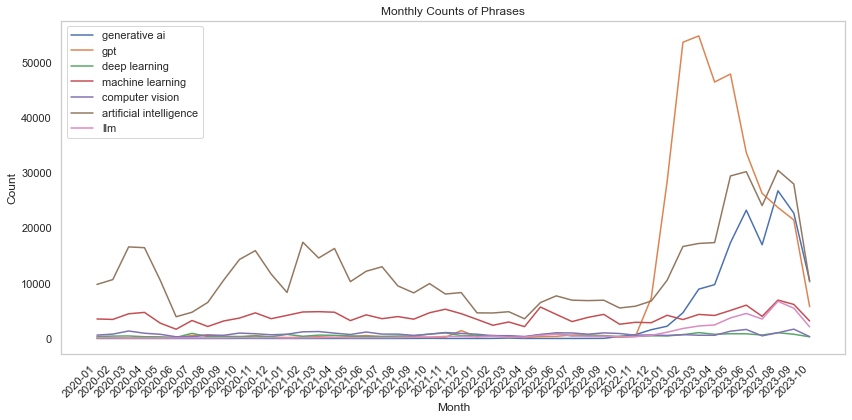

In [45]:
plt.figure(figsize=(12, 6))
for phrase in phrases:
    plt.plot(monthly_counts.index.astype(str).values, monthly_counts[phrase].values, label=phrase)

plt.title('Monthly Counts of Phrases')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.grid(False)
plt.tight_layout()
plt.show()